In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from pdb import set_trace as bp
from keras.models import Model
from keras.layers import Input, SeparableConv2D, Concatenate
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, UpSampling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [18]:
features_idx = train_features[1000,::]
print(features_idx.shape)
img_num = np.random.randint(features_idx.shape[0])
print('img_num ',img_num)
im = features_idx[img_num]
print(im.shape)

(32, 32, 3)
img_num  27
(32, 3)


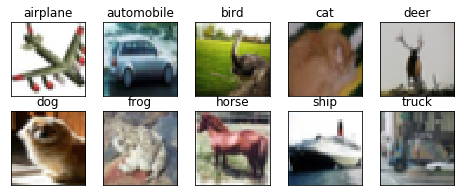

In [19]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#function for skip connection and downsampling to concatenate layers
def skipconnection_down(*argv):
  downsamplefactor = []
  
  for fmap in argv:
    downsamplefactor.append(fmap.get_shape().as_list()[2])
  
  minsize = min(downsamplefactor)
  downsamplefactor = [i/minsize for i in downsamplefactor]
  
  toconcat = []
  for cnt,fmap in enumerate(argv):
    if downsamplefactor[cnt] != 1:
      toconcat.append(AveragePooling2D(pool_size=(downsamplefactor[cnt],downsamplefactor[cnt]))(fmap))
    else:
      toconcat.append(fmap)
    
  afterconcat = Concatenate()(toconcat)
  print('toconcat[0].get_shape().as_list() : ',toconcat[0].get_shape().as_list())
  oneone = Convolution2D(toconcat[0].get_shape().as_list()[3],1,1)(afterconcat)
  return oneone

In [24]:
input = Input(shape=(32,32,3))

x = SeparableConv2D(32, 5, 5, border_mode='same')(input)                            
x = Activation('relu')(x)
x1 = BatchNormalization()(x)

x = Convolution2D(32, 5, 5, border_mode='same')(x1)
x = Activation('relu')(x)
x2 = BatchNormalization()(x)

x = Convolution2D(32, 5, 5, border_mode='same')(x2)
x = Activation('relu')(x)
x3 = BatchNormalization()(x)

concat1 = skipconnection_down(x1,x3)

x = SeparableConv2D(32, 5, 5, border_mode='same')(concat1)                            
x = Activation('relu')(x)
x4 = BatchNormalization()(x)

concat2 = skipconnection_down(x1,x4)

x5 = MaxPooling2D(pool_size=(2, 2),padding='same')(concat2)                                             

x = SeparableConv2D(32, 3, 3, border_mode='same')(x5)                            
x = Activation('relu')(x)
x6 = BatchNormalization()(x)

concat3 = skipconnection_down(x4,x6)

x = Convolution2D(32, 5, 5, border_mode='same')(concat3)
x = Activation('relu')(x)
x7 = BatchNormalization()(x)

concat4 = skipconnection_down(x3,x4,x6,x7)

x = SeparableConv2D(32, 3, 3, border_mode='same')(concat4)                            
x = Activation('relu')(x)
x8 = BatchNormalization()(x)

concat5 = skipconnection_down(x1,x3,x4,x6,x7,x8)

x = SeparableConv2D(32, 5, 5, border_mode='same')(concat5)                            
x = Activation('relu')(x)
x9 = BatchNormalization()(x)

concat6 = skipconnection_down(x1,x4,x6,x8,x9)

x10 = MaxPooling2D(pool_size=(2, 2))(concat6)                                             

concat7 = skipconnection_down(x7,x10)

x = Convolution2D(32, 5, 5, border_mode='same')(concat7)
x = Activation('relu')(x)
x11 = BatchNormalization()(x)

concat8 = skipconnection_down(x2,x4,x8,x11)

x = SeparableConv2D(32, 5, 5, border_mode='same')(concat8)                            
x = Activation('relu')(x)
x12 = BatchNormalization()(x)

concat9 = skipconnection_down(x2,x3,x6,x11,x12)

x = Convolution2D(32, 3, 3, border_mode='same')(concat9)
x = Activation('relu')(x)
x13 = BatchNormalization()(x)

concat10 = skipconnection_down(x1,x3,x4,x6,x8,x12,x13)

x = SeparableConv2D(32, 5, 5, border_mode='same')(concat10)                            
x = Activation('relu')(x)
x14 = BatchNormalization()(x)

concat11 = skipconnection_down(x4,x8,x12,x14)

x = Convolution2D(10,1,1)(concat11)
x = Activation('relu')(x)
x15 = BatchNormalization()(x)

x16 = Convolution2D(10,8,8)(x15)

x = Flatten()(x16)                                                                  
output = Activation('softmax')(x)


model = Model(inputs=input, outputs=output)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.0001)

# compile function of model class configures the network for training. 
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`


toconcat[0].get_shape().as_list() :  [None, 32, 32, 32]
toconcat[0].get_shape().as_list() :  [None, 32, 32, 32]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`


toconcat[0].get_shape().as_list() :  [None, 16, 16, 32]
toconcat[0].get_shape().as_list() :  [None, 16, 16, 32]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`


toconcat[0].get_shape().as_list() :  [None, 16, 16, 32]
toconcat[0].get_shape().as_list() :  [None, 16, 16, 32]
toconcat[0].get_shape().as_list() :  [None, 8, 8, 32]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`


toconcat[0].get_shape().as_list() :  [None, 8, 8, 32]
toconcat[0].get_shape().as_list() :  [None, 8, 8, 32]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`


toconcat[0].get_shape().as_list() :  [None, 8, 8, 32]
toconcat[0].get_shape().as_list() :  [None, 8, 8, 32]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8))`


In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 32, 32, 32)   0           separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 32)   128         activation_15[0][0]              
__________________________________________________________________________________________________
conv2d_19 

In [0]:
from keras.callbacks import ModelCheckpoint

# checkpoint
filepath = "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max',period=1)
callbacks_list = [checkpoint]


In [0]:
# load model
model = load_model("saved-model-{epoch:26}-{val_acc:.2f}.hdf5")

In [0]:
# Fit the model
#model.fit(X, Y, validation_split=0.33, epochs=10, batch_size=10, callbacks=callbacks_list, verbose=0)

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, featurewise_center=True,featurewise_std_normalization=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[learning_rate_reduction], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=195, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_ce

Epoch 1/100
195/195 [==============================] - 1366s 7s/step - loss: 1.3405 - acc: 0.5139 - val_loss: 1.3198 - val_acc: 0.5349
Epoch 2/100
195/195 [==============================] - 1360s 7s/step - loss: 1.0345 - acc: 0.6345 - val_loss: 1.0478 - val_acc: 0.6412
Epoch 3/100
195/195 [==============================] - 1359s 7s/step - loss: 0.8768 - acc: 0.6941 - val_loss: 1.0181 - val_acc: 0.6540
Epoch 4/100
195/195 [==============================] - 1371s 7s/step - loss: 0.7692 - acc: 0.7312 - val_loss: 0.8726 - val_acc: 0.7016
Epoch 5/100
195/195 [==============================] - 1358s 7s/step - loss: 0.6802 - acc: 0.7631 - val_loss: 0.8686 - val_acc: 0.7056
Epoch 6/100
195/195 [==============================] - 1360s 7s/step - loss: 0.6197 - acc: 0.7844 - val_loss: 0.9971 - val_acc: 0.6854
Epoch 7/100
195/195 [==============================] - 1360s 7s/step - loss: 0.5571 - acc: 0.8052 - val_loss: 0.9955 - val_acc: 0.6845
Epoch 8/100
195/195 [==============================] - 